<a href="https://colab.research.google.com/github/harrisonkurunathan/emul8-sample-contiki-project/blob/master/AntiaircraftGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

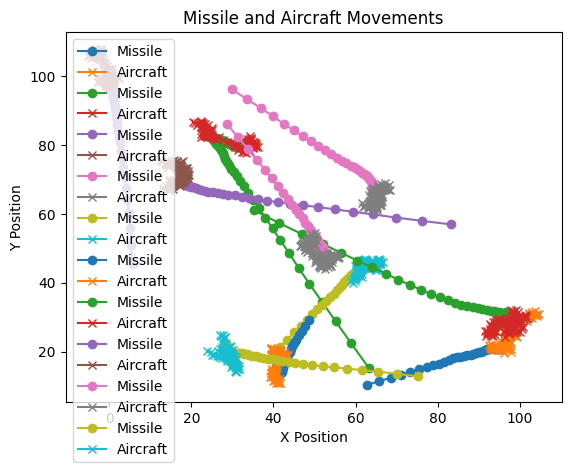

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate missile and aircraft movement
def simulate_movement(num_missiles, num_steps):
    movements = []
    for _ in range(num_missiles):
        missile_x, missile_y = np.random.rand(2) * 100  # Random initial position for missile
        aircraft_x, aircraft_y = np.random.rand(2) * 100  # Random initial position for aircraft
        trajectory = []
        for _ in range(num_steps):
            trajectory.append([missile_x, missile_y, aircraft_x, aircraft_y])
            missile_x += (aircraft_x - missile_x) * 0.1  # Missile moves towards the aircraft
            missile_y += (aircraft_y - missile_y) * 0.1
            aircraft_x += (np.random.rand() - 0.5) * 2  # Random movement in x for aircraft
            aircraft_y += (np.random.rand() - 0.5) * 2  # Random movement in y for aircraft
        movements.append(trajectory)
    return np.array(movements)

num_missiles = 10
num_steps = 100
data = simulate_movement(num_missiles, num_steps)

# Visualize the movements
for missile in data:
    plt.plot(missile[:, 0], missile[:, 1], marker='o', label='Missile')
    plt.plot(missile[:, 2], missile[:, 3], marker='x', label='Aircraft')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Missile and Aircraft Movements')
plt.legend()
plt.show()


In [2]:
from sklearn.preprocessing import MinMaxScaler

def prepare_data(data, time_steps):
    X, y = [], []
    for movement in data:
        for i in range(len(movement) - time_steps):
            X.append(movement[i:i+time_steps, :4])
            y.append(movement[i+time_steps, :2])  # Predict missile position
    return np.array(X), np.array(y)

time_steps = 5
X, y = prepare_data(data, time_steps)

# Normalize the data
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y)

print("Input shape:", X.shape)
print("Output shape:", y.shape)


Input shape: (950, 5, 4)
Output shape: (950, 2)


Epoch 1/100
12/12 [==============================] - 5s 78ms/step - loss: 0.4327 - val_loss: 0.0735
Epoch 2/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0974 - val_loss: 0.0105
Epoch 3/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0356 - val_loss: 0.0125
Epoch 4/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0117 - val_loss: 0.0055
Epoch 5/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0033 - val_loss: 0.0059
Epoch 6/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0078
Epoch 7/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0068
Epoch 8/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 9/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0056
Epoch 10/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0052
Epoc

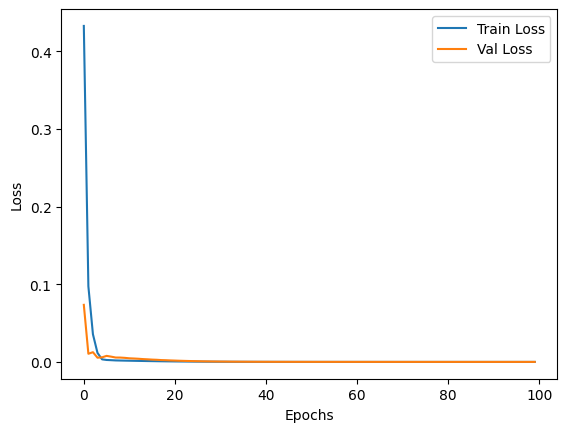

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Build the GRU model
model = Sequential()
model.add(GRU(50, input_shape=(time_steps, 4)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X, y, epochs=100, batch_size=64, validation_split=0.2)

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 21ms/step


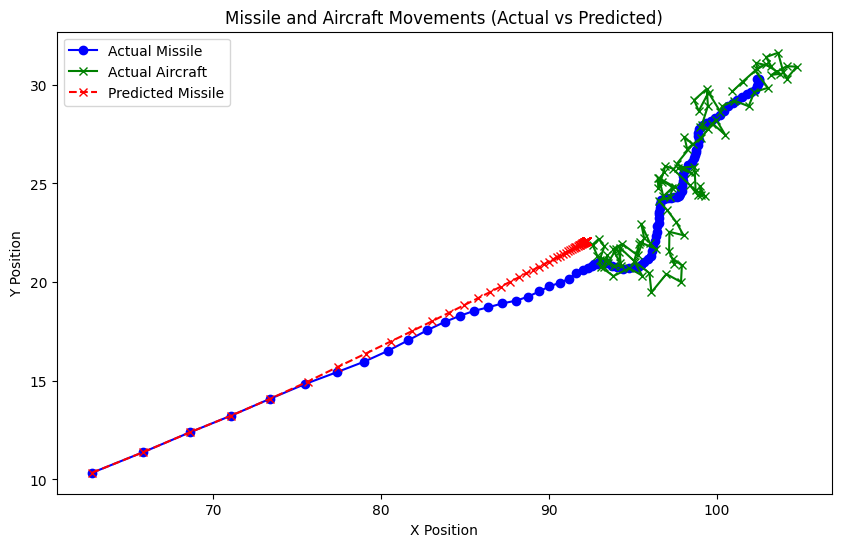

In [6]:
# Predict future positions
def predict_future_positions(model, initial_positions, time_steps, future_steps):
    future_positions = initial_positions.copy()
    for _ in range(future_steps):
        input_data = future_positions[-time_steps:]
        input_data = scaler_X.transform(input_data)
        input_data = input_data[np.newaxis, ...]
        next_position = model.predict(input_data)
        next_position = scaler_y.inverse_transform(next_position)
        # Ensure next_position has the correct dimensions
        next_position = next_position.reshape(1, 2)
        future_positions = np.vstack([future_positions, np.hstack([next_position, future_positions[-1, 2:].reshape(1, 2)])])
    return future_positions

# Example of prediction
missile_index = 0
initial_positions = data[missile_index][:time_steps]
predicted_positions = predict_future_positions(model, initial_positions, time_steps, num_steps-time_steps)

# Plot actual vs predicted positions with overlapping
plt.figure(figsize=(10, 6))
plt.plot(data[missile_index][:, 0], data[missile_index][:, 1], marker='o', linestyle='-', label='Actual Missile', color='blue')
plt.plot(data[missile_index][:, 2], data[missile_index][:, 3], marker='x', linestyle='-', label='Actual Aircraft', color='green')
plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], marker='x', linestyle='--', label='Predicted Missile', color='red')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Missile and Aircraft Movements (Actual vs Predicted)')
plt.legend()
plt.show()
